In [1]:
from IPython.core.magic import register_cell_magic
@register_cell_magic
def skip(line, cell):
    return

from peak_modeling import *
import matplotlib.pyplot as plt

model = peaks_model_R24

In [2]:
def plot_output(T, au, dR, ax, **kwargs):
  nu, nF = model(T, au, dR)
  ax.loglog(nu, nF, **kwargs)

def create_legend_colors(ax, names, colors, **kwargs):
  dummy_col = [ax.plot([], [], c=col, ls='-')[0] for col in colors]
  legend = ax.legend(dummy_col, names, **kwargs)
  return legend

def create_legend_styles(ax, names, styles, **kwargs):
  dummy_lst = [ax.plot([], [], c='k', ls=l)[0] for l in styles]
  legend = ax.legend(dummy_lst, names, **kwargs)
  return legend

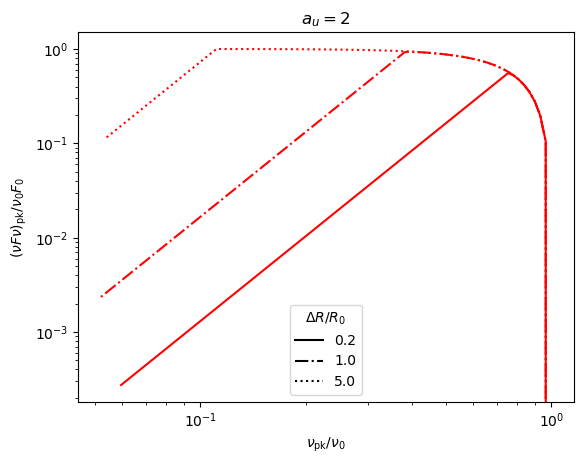

In [6]:
T = np.geomspace(1, 10, 100)
dRs = [0.2, 1, 5]
lstyles = ['-', '-.', ':']
fig, ax = plt.subplots()
ax.set_xlabel('$\\nu_{\\rm pk}/\\nu_0$')
ax.set_ylabel('$(\\nu F\\nu)_{\\rm pk}/\\nu_0F_0$')
ax.set_title('$a_u=2$')
legend = create_legend_styles(ax, [f'{dR:.1f}' for dR in dRs], lstyles,
    title='$\\Delta R/R_0$')

for dR, ls in zip(dRs, lstyles):
  plot_output(T, 2, dR, ax, c='r', ls=ls)


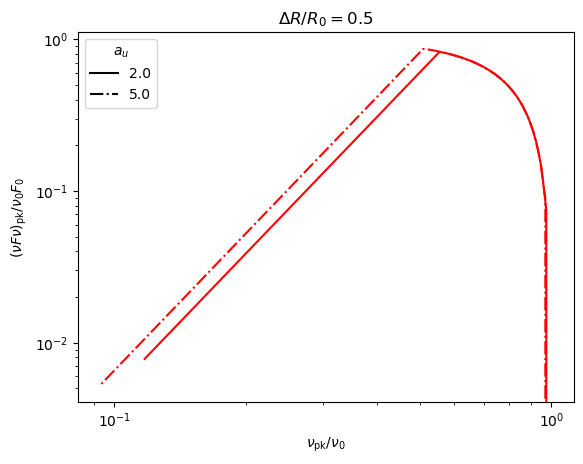

In [8]:
T = np.geomspace(1, 5, 100)
aus = [2, 5]
lstyles = ['-', '-.', ':']
fig, ax = plt.subplots()
ax.set_xlabel('$\\nu_{\\rm pk}/\\nu_0$')
ax.set_ylabel('$(\\nu F\\nu)_{\\rm pk}/\\nu_0F_0$')
ax.set_title('$\Delta R/R_0=0.5$')
legend = create_legend_styles(ax, [f'{au:.1f}' for au in aus], lstyles,
    title='$a_u$')

for au, ls in zip(aus, lstyles):
  plot_output(T, au, 0.5, ax, c='r', ls=ls)